앞에서 사용한 코드 불러오기

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

# 파일 경로 설정
file_path = "/content/drive/My Drive/human_activity/features.txt"

feature_name_df = pd.read_csv(file_path, sep='\s+', header=None, names=['column_index', 'column_name'])

#피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name=feature_name_df.iloc[:,1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])


전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [14]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index']>1].count())
feature_dup_df[feature_dup_df['column_index']>1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [15]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data = old_feature_name_df.groupby('column_name').cumcount(),
                                  columns = ['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how ='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name',
                                                              'dup_cnt']].apply(lambda x:x[0]+'_'+str(x[1])
                                                              if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [16]:
import pandas as pd

def get_human_dataset():

    # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당
    feature_name_df = pd.read_csv(file_path, sep='\s+', header=None, names=['column_index', 'column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()

    #학습 피처 데이터세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
    X_train =pd.read_csv("/content/drive/My Drive/human_activity/train/X_train.txt", sep='\s+', names = feature_name)
    X_test =pd.read_csv("/content/drive/My Drive/human_activity/test/X_test.txt", sep='\s+',names = feature_name)

    #학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
    y_train = pd.read_csv("/content/drive/My Drive/human_activity/train/y_train.txt", sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv("/content/drive/My Drive/human_activity/test/y_test.txt", sep='\s+', header=None, names=['action'])

    #로드된 학습/데이터용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

<ipython-input-15-14ed38ff8a1c>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if x[1]>0 else x[0], axis=1)
<ipython-input-15-14ed38ff8a1c>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'dup_cnt']].apply(lambda x:x[0]+'_'+str(x[1])


In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#예제 반복 시마다 동일한 예측결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

#DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())


결정 트리 예측 정확도:0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 156, 'splitter': 'best'}


여기까지 앞에서 사용한 get_human_dataset 불러온 코드들

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

#GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도:{0:.4f}'.format(gb_accuracy))
print("GBM 수행시간:{0:.1f}초".format(time.time() - start_time))

GBM 정확도:0.9379
GBM 수행시간:1228.4초


In [19]:
import xgboost as xgb
from xgboost import XGBClassifier

In [20]:
import xgboost

print(xgboost.__version__)

3.0.0


In [21]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target
cancer_df = pd.DataFrame(data = features, columns = dataset.feature_names)
cancer_df['target']=labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [22]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [23]:
#cancer_df 에서 feature용 DataFrame과 Label용 Series 객체 추출
#맨 마지막 칼럼이 Label -> Feauture용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지를 :-1 슬라이싱으로 추출
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

#전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state = 156)

#위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [24]:
import xgboost as xgb

In [25]:
# XGBoost 최신 버전으로 업그레이드
!pip install --upgrade xgboost


In [26]:
import xgboost as xgb
from scipy import sparse
#만약 구버전 XGBoost에서 DataFrame으로 DMatrix 생성이 안될경우 X_train.values로 넘파이 변환
#학습, 검증, 테스트용 DMatrix를 생성

#버전 문제 때문인지 아무리 해도 아래 셀과 같은 오류가 떠서 챗지피티로 코드 수정해서 돌렸습니다
# X_tr을 sparse matrix로 변환
X_tr_sparse = sparse.csr_matrix(X_tr)

# DMatrix 생성
dtr = xgb.DMatrix(data=X_tr_sparse, label=y_tr)
dval = xgb.DMatrix(data=sparse.csr_matrix(X_val), label=y_val)
dtest = xgb.DMatrix(data=sparse.csr_matrix(X_test), label=y_test)


In [27]:
#만약 구버전 XGBoost에서 DataFrame으로 DMatrix 생성이 안될경우 X_train.values로 넘파이 변환
#학습, 검증, 테스트용 DMatrix를 생성
dtr = xgb.DMatrix(data=X_tr.to_numpy(), label=y_tr.to_numpy())
dval = xgb.DMatrix(data=X_val.to_numpy(), label=y_val.to_numpy())
dtest = xgb.DMatrix(data=X_test.to_numpy(), label=y_test.to_numpy())



In [28]:
params = { 'max_depth':3,
          'eta': 0.05,
           'objective':'binary:logistic',
           'eval_metric':'logloss'}

num_rounds = 400

In [29]:
# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval' 로 명기합니다
eval_list = [(dtr, 'train'), (dval, 'eval')] #또는 eval_list = [(dval,'eva;')]만 명기해도 무방

#하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain = dtr, num_boost_round = num_rounds, \
                      early_stopping_rounds = 50, evals = eval_list)

[0]	train-logloss:0.62473	eval-logloss:0.63088
[1]	train-logloss:0.58662	eval-logloss:0.60461
[2]	train-logloss:0.55210	eval-logloss:0.58205
[3]	train-logloss:0.52068	eval-logloss:0.56165
[4]	train-logloss:0.49173	eval-logloss:0.54101
[5]	train-logloss:0.46517	eval-logloss:0.52206
[6]	train-logloss:0.44009	eval-logloss:0.50271
[7]	train-logloss:0.41646	eval-logloss:0.48606
[8]	train-logloss:0.39505	eval-logloss:0.46961
[9]	train-logloss:0.37523	eval-logloss:0.45485
[10]	train-logloss:0.35682	eval-logloss:0.44120
[11]	train-logloss:0.33964	eval-logloss:0.43123
[12]	train-logloss:0.32279	eval-logloss:0.41962
[13]	train-logloss:0.30783	eval-logloss:0.40848
[14]	train-logloss:0.29308	eval-logloss:0.39857
[15]	train-logloss:0.27928	eval-logloss:0.38945
[16]	train-logloss:0.26681	eval-logloss:0.38171
[17]	train-logloss:0.25498	eval-logloss:0.37381
[18]	train-logloss:0.24352	eval-logloss:0.36656
[19]	train-logloss:0.23307	eval-logloss:0.36014
[20]	train-logloss:0.22290	eval-logloss:0.35395
[2

In [30]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값을 결정하여 List 객체인 preds에 저장
preds = [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨
[0.938 0.004 0.776 0.058 0.975 1.    0.999 0.999 0.998 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


3장에서 쓴3장에서 쓴 get_clf_eval 코드 불러오기

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [32]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[35  2]
 [ 2 75]]
정확도: 0.9649, 정밀도: 0.9740, 재현율: 0.9740,    F1: 0.9740, AUC:0.9965


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

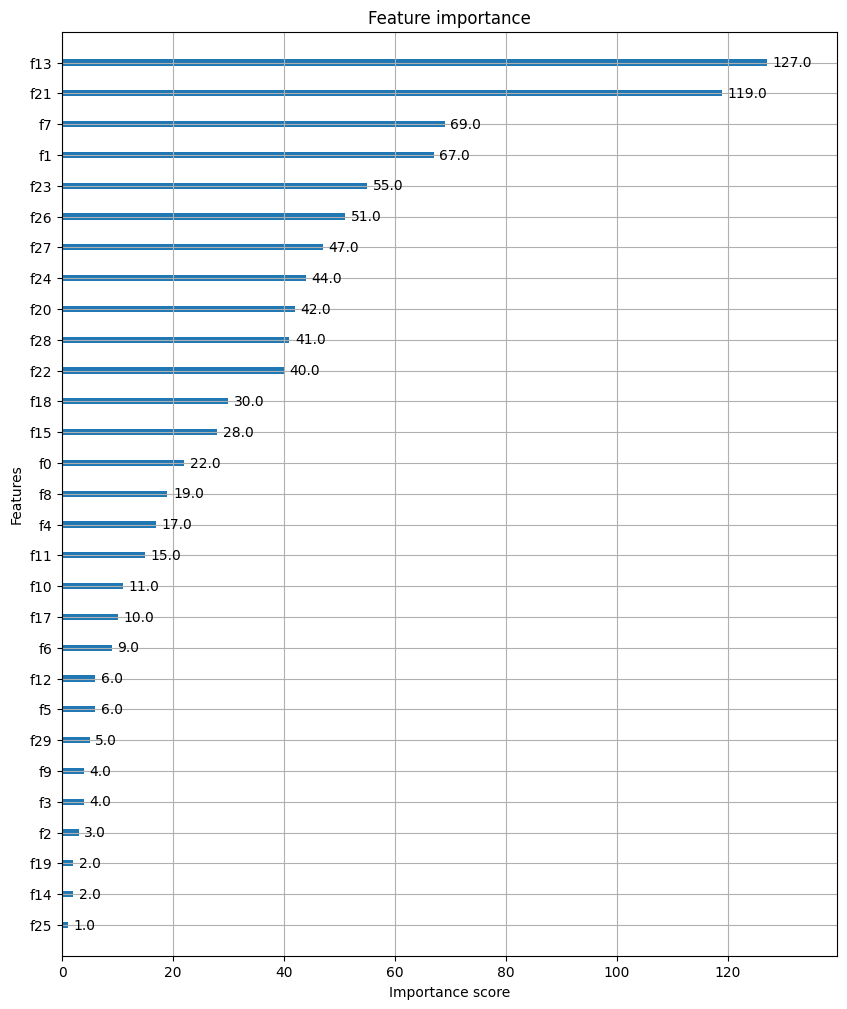

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10,12))
plot_importance(xgb_model, ax = ax)

In [34]:
pip install --upgrade scikit-learn xgboost

In [35]:
import pandas as pd
import numpy as np

# X_train이 DataFrame인지 확인
if isinstance(X_train, pd.DataFrame):
    print("X_train is a DataFrame")
else:
    print("X_train is NOT a DataFrame, converting to DataFrame")
    X_train = pd.DataFrame(X_train)

# y_train이 Series 또는 numpy 배열인지 확인
if isinstance(y_train, (pd.Series, np.ndarray)):
    print("y_train is a valid type")
else:
    print("y_train is NOT a valid type, converting to Series")
    y_train = pd.Series(y_train)


X_train is a DataFrame
y_train is a valid type


In [36]:
dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
dtest = xgb.DMatrix(X_test.values)

In [39]:
from xgboost import XGBClassifier
import pandas as pd
import xgboost as xgb

# Ensure X_train and y_train are in proper format
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train
X_test = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

# Create an XGBClassifier instance
xgb_wrapper = XGBClassifier(
    n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric="logloss"
)

# Train the model (DO NOT use DMatrix)
xgb_wrapper.fit(X_train, y_train, verbose=True)

# Make predictions
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]


In [40]:
#사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

#Warning 메시지를 없애기 위해 eval_metric 값을 XGBClassifier 생성 인자로 입력
xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.05, max_depth = 3,eval_metric = 'logloss')
xgb_wrapper.fit(X_train, y_train, verbose = True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

In [41]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9951


In [42]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [43]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


In [44]:
import xgboost
print(xgboost.__version__)


3.0.0


버전차이가 있어서 책과 동일하게 할 경우 다음 셀의 코드와 같은 오류가 나서 코드를 책과 다르게 수정해서 진행했습니다..!

In [45]:
from xgboost import XGBClassifier

xgb_wrapper=XGBClassifier(n_estimators=400,learning_rate=0.05,max_depth=3,early_stopping_rounds=50,eval_metric="logloss")
evals=[(X_tr,y_tr),(X_val,y_val)]
xgb_wrapper.fit(X_tr,y_tr,eval_set=evals,verbose=True)

ws50_preds=xgb_wrapper.predict(X_test)
ws50_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.62473	validation_1-logloss:0.63088
[1]	validation_0-logloss:0.58662	validation_1-logloss:0.60461
[2]	validation_0-logloss:0.55210	validation_1-logloss:0.58205
[3]	validation_0-logloss:0.52068	validation_1-logloss:0.56165
[4]	validation_0-logloss:0.49173	validation_1-logloss:0.54101
[5]	validation_0-logloss:0.46517	validation_1-logloss:0.52206
[6]	validation_0-logloss:0.44009	validation_1-logloss:0.50271
[7]	validation_0-logloss:0.41646	validation_1-logloss:0.48606
[8]	validation_0-logloss:0.39505	validation_1-logloss:0.46961
[9]	validation_0-logloss:0.37523	validation_1-logloss:0.45485
[10]	validation_0-logloss:0.35682	validation_1-logloss:0.44120
[11]	validation_0-logloss:0.33964	validation_1-logloss:0.43123
[12]	validation_0-logloss:0.32279	validation_1-logloss:0.41962
[13]	validation_0-logloss:0.30783	validation_1-logloss:0.40848
[14]	validation_0-logloss:0.29308	validation_1-logloss:0.39857
[15]	validation_0-logloss:0.27928	validation_1-logloss:0.38945
[1

In [49]:
from xgboost import XGBClassifier

# 최신 XGBoost에 맞게 early_stopping 설정
xgb_wrapper = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    eval_metric="logloss",
    early_stopping=True  # ✅ 최신 XGBoost에서는 early_stopping=True 설정
)

# 검증 데이터 설정
evals = [(X_tr, y_tr), (X_val, y_val)]

# 모델 학습
xgb_wrapper.fit(
    X_tr, y_tr,
    eval_set=evals,
    verbose=True
)

# 예측
ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

#TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'오류가 나서,, 챗지피티 이용해서 수정해서 진행

[0]	validation_0-logloss:0.62473	validation_1-logloss:0.63088
[1]	validation_0-logloss:0.58662	validation_1-logloss:0.60461
[2]	validation_0-logloss:0.55210	validation_1-logloss:0.58205
[3]	validation_0-logloss:0.52068	validation_1-logloss:0.56165
[4]	validation_0-logloss:0.49173	validation_1-logloss:0.54101
[5]	validation_0-logloss:0.46517	validation_1-logloss:0.52206
[6]	validation_0-logloss:0.44009	validation_1-logloss:0.50271
[7]	validation_0-logloss:0.41646	validation_1-logloss:0.48606
[8]	validation_0-logloss:0.39505	validation_1-logloss:0.46961
[9]	validation_0-logloss:0.37523	validation_1-logloss:0.45485
[10]	validation_0-logloss:0.35682	validation_1-logloss:0.44120
[11]	validation_0-logloss:0.33964	validation_1-logloss:0.43123
[12]	validation_0-logloss:0.32279	validation_1-logloss:0.41962
[13]	validation_0-logloss:0.30783	validation_1-logloss:0.40848
[14]	validation_0-logloss:0.29308	validation_1-logloss:0.39857
[15]	validation_0-logloss:0.27928	validation_1-logloss:0.38945
[1

In [50]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차 행렬
[[35  2]
 [ 2 75]]
정확도: 0.9649, 정밀도: 0.9740, 재현율: 0.9740,    F1: 0.9740, AUC:0.9961


In [52]:
from xgboost import XGBClassifier

# XGBClassifier 생성 (early_stopping_rounds는 여기에서 설정)
xgb_wrapper = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    eval_metric="logloss",
    early_stopping_rounds=10  # ✅ 최신 XGBoost에서는 여기서 설정
)

# 검증 데이터 설정
evals = [(X_tr, y_tr), (X_val, y_val)]

# 모델 학습
xgb_wrapper.fit(
    X_tr, y_tr,
    eval_set=evals,
    verbose=True
)

# 테스트 데이터 예측
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

# 성능 평가 함수 호출
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

#아래 셀과 같은 오류가 나서 코드 수정 진행

[0]	validation_0-logloss:0.62473	validation_1-logloss:0.63088
[1]	validation_0-logloss:0.58662	validation_1-logloss:0.60461
[2]	validation_0-logloss:0.55210	validation_1-logloss:0.58205
[3]	validation_0-logloss:0.52068	validation_1-logloss:0.56165
[4]	validation_0-logloss:0.49173	validation_1-logloss:0.54101
[5]	validation_0-logloss:0.46517	validation_1-logloss:0.52206
[6]	validation_0-logloss:0.44009	validation_1-logloss:0.50271
[7]	validation_0-logloss:0.41646	validation_1-logloss:0.48606
[8]	validation_0-logloss:0.39505	validation_1-logloss:0.46961
[9]	validation_0-logloss:0.37523	validation_1-logloss:0.45485
[10]	validation_0-logloss:0.35682	validation_1-logloss:0.44120
[11]	validation_0-logloss:0.33964	validation_1-logloss:0.43123
[12]	validation_0-logloss:0.32279	validation_1-logloss:0.41962
[13]	validation_0-logloss:0.30783	validation_1-logloss:0.40848
[14]	validation_0-logloss:0.29308	validation_1-logloss:0.39857
[15]	validation_0-logloss:0.27928	validation_1-logloss:0.38945
[1

In [51]:
#early_stopping_rounds를 10으로 설정하고 재학습
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 10,
                eval_metric ="logloss", eval_set=evals, verbose = True)

ws10_preds =  xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

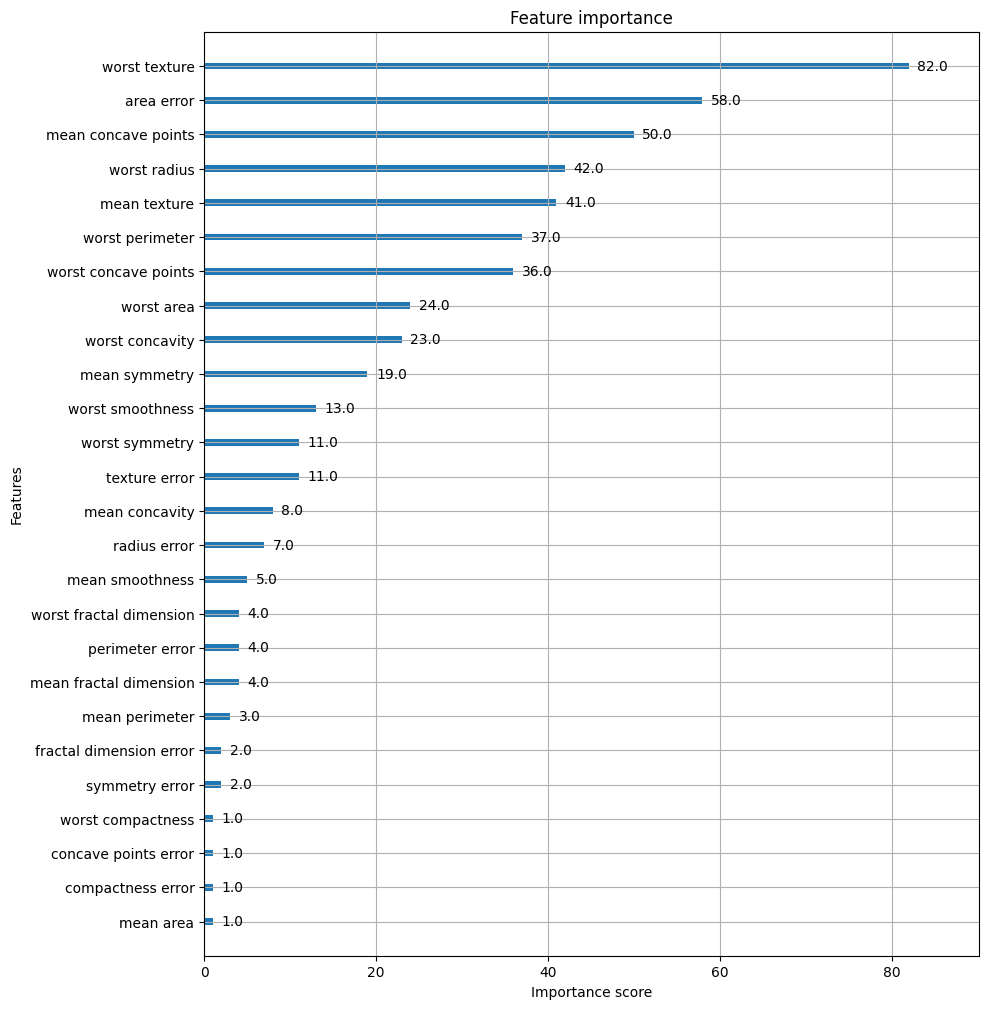

In [53]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10,12))
#사이킷런 래퍼 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax = ax)

# 07.LightGBM

In [54]:
import lightgbm
from lightgbm import LGBMClassifier

In [55]:
pip install lightgbm==3.3.2

In [56]:
#LightGBM의 파이썬 패키지인 lightbgm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data = dataset.data, columns = dataset.feature_names)
cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]


#전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state= 156)

#위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 156)

#앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators = 400, learning_rate = 0.05)

#LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_tr, y_tr), (X_val,y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 50, eval_metric = "logloss",
                 eval_set = evals, verbose = True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

In [57]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9877


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

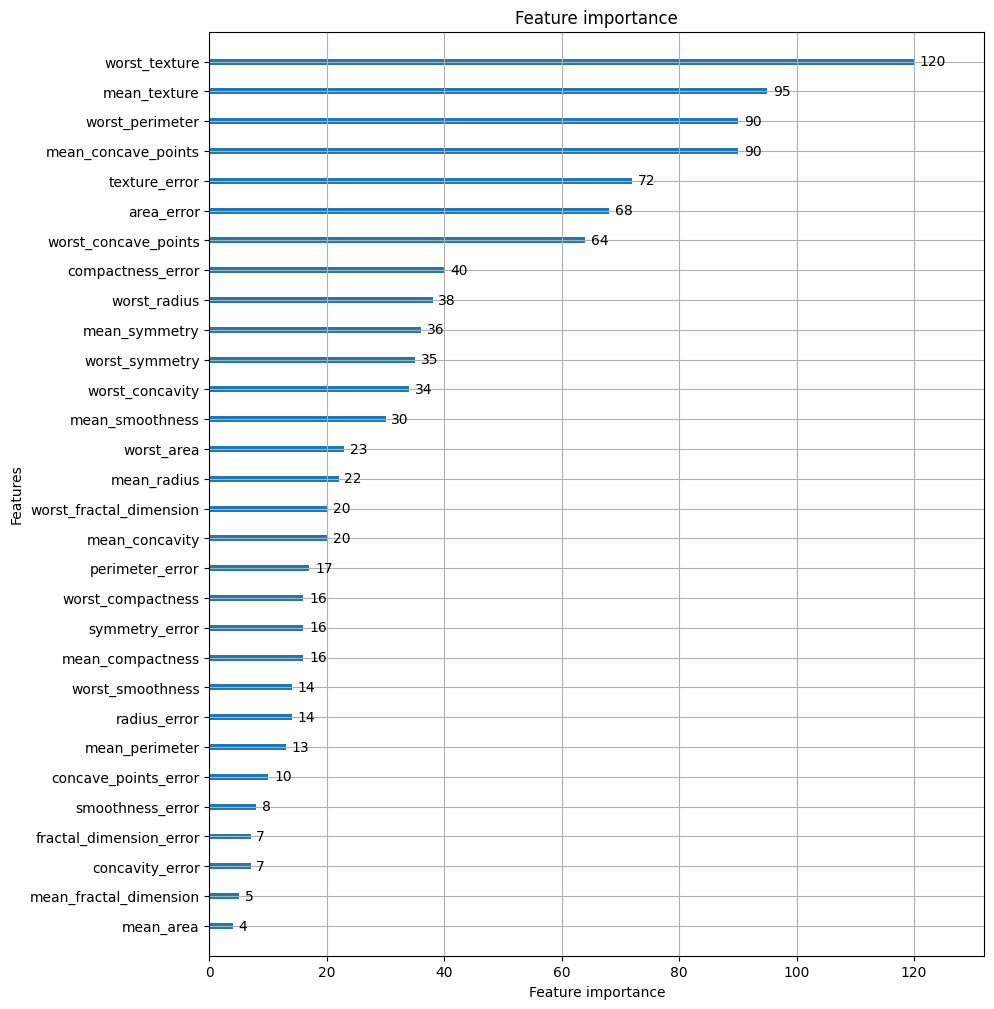

In [59]:
#plot_importance()를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize =(10,12))
plot_importance(lgbm_wrapper, ax = ax)

# 08. 베이지안 최적화 기반의 HyperOpt를 이용한 하이퍼 파라미터 튜닝

In [63]:
params = {
    'max_depth': [10, 20, 30, 40, 50],
    'num_leaves': [35, 45, 55, 65],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [10, 20, 30, 40],
    'reg_alpha': [0.01, 0.05, 0.1]
}
# = 사용 시 오류남

In [64]:
from hyperopt import hp

#-10 ~ 10까지 1간격을 가지는 입력 변수 x와 -15 ~ 15까지 1간격으로 입력변수 y 설정
search_space = {'x': hp.quniform('x', -10, 10, 1), 'y':hp.quniform('y', -15, 15, 1)}

In [67]:
from hyperopt import STATUS_OK

#목적함수를 생성. 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고, 특정값을 반환
def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y

    return retval

In [69]:
from hyperopt import fmin, tpe, Trials
#입력 결괏값을 저장한 Trials 객체값 생성
trial_val = Trials()

#목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals=5)로 찾아냄
best_01 = fmin(fn = objective_func, space = search_space, algo = tpe.suggest, max_evals = 5,
               trials = trial_val, rstate = np.random.default_rng(seed = 0))
print('best:', best_01)

100%|██████████| 5/5 [00:00<00:00, 716.80trial/s, best loss: -224.0]
best: {'x': np.float64(-4.0), 'y': np.float64(12.0)}


In [70]:
trial_val = Trials()

#max_evals를 20회로 늘려서 재테스트
best_02 = fmin(fn = objective_func, space = search_space, algo = tpe.suggest, max_evals = 20,
               trials = trial_val, rstate = np.random.default_rng(seed = 0))
print('best:', best_02)

100%|██████████| 20/20 [00:00<00:00, 904.83trial/s, best loss: -296.0]
best: {'x': np.float64(2.0), 'y': np.float64(15.0)}


In [71]:
#fmin()에 인자로 들어가는 Trials 객체의 result 속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
#리스트 내부의 개별 원소는  {'loss'：함수 반환값, 'status'：반환 상태값}와 같은 딕셔너리

print(trial_val.results)

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


In [72]:
#Trials 객체의 vals 속성에 에 {'입력변수명': 개별 수행 시마다 입력된 값 리스트} 형태로 저장됨
print(trial_val.vals)

{'x': [np.float64(-6.0), np.float64(-4.0), np.float64(4.0), np.float64(-4.0), np.float64(9.0), np.float64(2.0), np.float64(10.0), np.float64(-9.0), np.float64(-8.0), np.float64(-0.0), np.float64(-0.0), np.float64(1.0), np.float64(9.0), np.float64(6.0), np.float64(9.0), np.float64(2.0), np.float64(-2.0), np.float64(-4.0), np.float64(7.0), np.float64(-0.0)], 'y': [np.float64(5.0), np.float64(10.0), np.float64(-2.0), np.float64(12.0), np.float64(1.0), np.float64(15.0), np.float64(7.0), np.float64(-10.0), np.float64(0.0), np.float64(-5.0), np.float64(-3.0), np.float64(2.0), np.float64(4.0), np.float64(10.0), np.float64(3.0), np.float64(3.0), np.float64(-14.0), np.float64(-8.0), np.float64(11.0), np.float64(-0.0)]}


In [73]:
import pandas as pd
#results에서 loss 키값에 해당하는 밸류들을 추출하여 list로 생성
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

#DataFrame으로 생성
result_df = pd.DataFrame({'x': trial_val.vals['x'], 'y': trial_val.vals['y'], 'losses':losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


In [74]:
#전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state = 156)

#앞에서 추출한 학습 데이터를 다시 학습과 검증 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 156)

In [75]:
from hyperopt import hp

#max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
#colsample_bytree는 0.5에서 1 사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색
xgb_search_space = {'max_depth':hp.quniform('max_depth', 5, 20, 1),
                    'min_child_weight':hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree':hp.uniform('colsample_bytree', 0.5, 1),
                    }

In [76]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

#fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임
#XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함
#정확도는 높을수록 더 좋은 수치임. -1*정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환

def objective_func(search_space):
    #수행시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators = 100, max_depth = int(search_space['max_depth']),
                            min_child_weight = int(search_space['min_child_weight']),
                            learning_rate = search_space['learning_rate'],
                            colsample_bytree = search_space['colsample_bytree'],
                            eval_metric = 'logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring = 'accuracy', cv = 3)

    #accuracy는 cv = 3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함
    return {'loss':-1*np.mean(accuracy), 'status': STATUS_OK}

In [77]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func,
            space = xgb_search_space,
            algo = tpe.suggest,
            max_evals = 50,
            trials = trial_val, rstate = np.random.default_rng(seed = 9))
print('best:', best)

100%|██████████| 50/50 [00:19<00:00,  2.62trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': np.float64(0.858999866296754), 'learning_rate': np.float64(0.17459146963933464), 'max_depth': np.float64(20.0), 'min_child_weight': np.float64(2.0)}


In [78]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'],5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])
))

colsample_bytree:0.859, learning_rate:0.17459, max_depth:20, min_child_weight:2


earlystoppingrounds 오류로 코드 수정

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [82]:
from xgboost import XGBClassifier

# XGBClassifier 생성
xgb_wrapper = XGBClassifier(
    n_estimators=400,
    learning_rate=round(best['learning_rate'], 5),
    max_depth=int(best['max_depth']),
    min_child_weight=int(best['min_child_weight']),
    colsample_bytree=round(best['colsample_bytree'], 5)
)

# eval_set 설정
evals = [(X_tr, y_tr), (X_val, y_val)]

# 모델 학습 (early_stopping_rounds를 제외한 인자만 사용)
xgb_wrapper.fit(
    X_tr, y_tr,
    eval_set=evals,
    verbose=True
)

# 예측
preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

# 성능 평가
get_clf_eval(y_test, preds, pred_proba)


[0]	validation_0-logloss:0.53178	validation_1-logloss:0.57774
[1]	validation_0-logloss:0.43693	validation_1-logloss:0.53104
[2]	validation_0-logloss:0.36375	validation_1-logloss:0.46939
[3]	validation_0-logloss:0.30808	validation_1-logloss:0.42846
[4]	validation_0-logloss:0.26254	validation_1-logloss:0.39423
[5]	validation_0-logloss:0.22780	validation_1-logloss:0.36739
[6]	validation_0-logloss:0.19887	validation_1-logloss:0.35126
[7]	validation_0-logloss:0.17442	validation_1-logloss:0.33290
[8]	validation_0-logloss:0.15590	validation_1-logloss:0.31895
[9]	validation_0-logloss:0.13757	validation_1-logloss:0.30455
[10]	validation_0-logloss:0.12339	validation_1-logloss:0.29727
[11]	validation_0-logloss:0.11020	validation_1-logloss:0.28950
[12]	validation_0-logloss:0.09900	validation_1-logloss:0.28643
[13]	validation_0-logloss:0.09022	validation_1-logloss:0.28405
[14]	validation_0-logloss:0.08217	validation_1-logloss:0.27688
[15]	validation_0-logloss:0.07616	validation_1-logloss:0.27643
[1

# 11. 스태킹 앙상블

---



In [83]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size = 0.2, random_state = 0)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size = 0.2, random_state = 0)

In [84]:
#개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors = 4)
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators = 100)

#스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression()

In [85]:
#개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [86]:
#학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도:{0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도 : {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도 : {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도:0.9211
랜덤 포레스트 정확도 : 0.9649
결정 트리 정확도 : 0.9035
에이다부스트 정확도 : 0.9737


In [87]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

#transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [88]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도:{0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도:0.9649


CV 세트 기반의 스태킹


In [89]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

#개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    #지정된 n_folds 값으로 KFold 생성
    kf = KFold(n_splits = n_folds, shuffle = False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__, 'model 시작')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트: ', folder_counter, '시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [90]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
RandomForestClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
DecisionTreeClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
AdaBoostClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작


In [91]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


In [92]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
